In [1]:
import tensorflow as tf
from tensorflow import keras

### Simple Food Classifcation model

In [2]:
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from os.path import exists
from collections import defaultdict

def load_data(file_path, base_dir, max_per_class=None):
    image_paths = defaultdict(list)
    labels = []
    
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.split('/')
            class_name = parts[0].strip()
            img_path = f"{base_dir}/{class_name}/{parts[1].strip()}"
            image_paths[class_name].append(img_path)
    
    # Restrict the number of images per class
    final_image_paths = []
    final_labels = []
    for class_name, paths in image_paths.items():
        if max_per_class:
            paths = paths[:max_per_class]  # Limit to max_per_class images
        final_image_paths.extend(paths)
        final_labels.extend([class_name] * len(paths))
    
    return final_image_paths, final_labels

def load_and_preprocess_images(image_paths, target_size=(224, 224)):
    images = []
    for img_path in image_paths:
        img_path = img_path + '.jpg'
        if not exists(img_path):
            print(f"Image path does not exist: {img_path}")
            continue
        img = Image.open(img_path)
        img = img.convert('RGB')  # Ensure all images are in RGB mode
        img = img.resize(target_size)
        img_array = np.array(img)
        
        # Check if the image shape is correct
        if img_array.shape != (target_size[0], target_size[1], 3):
            print(f"Unexpected image shape: {img_array.shape} for image {img_path}")
            continue
        
        images.append(img_array)
    return np.array(images)

# Load training and testing data with fewer files per class
train_image_paths, train_labels = load_data(
    '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/meta/train.txt',
    '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images',
    max_per_class=80  # Take at most 50 images per class
)
test_image_paths, test_labels = load_data(
    '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/meta/test.txt',
    '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images',
    max_per_class=20  # Take at most 20 images per class
)

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Preprocess images
print('train_image_paths:', train_image_paths)
train_images = load_and_preprocess_images(train_image_paths)
test_images = load_and_preprocess_images(test_image_paths)

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert to NumPy arrays for model input
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels_encoded = np.array(train_labels_encoded)
test_labels_encoded = np.array(test_labels_encoded)

print(f"Classes: {label_encoder.classes_}")


train_image_paths: ['/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images/apple_pie/1005649', '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images/apple_pie/1014775', '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images/apple_pie/1026328', '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images/apple_pie/1028787', '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images/apple_pie/1043283', '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images/apple_pie/1050519', '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images/apple_pie/1057749', '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images/apple_pie/1057810', '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_

In [3]:
## using the data in a Tensorflow tensor
import tensorflow as tf
# Define a data augmentation function
def data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)  # Random brightness adjustment
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Random contrast adjustment
    image = tf.image.random_crop(image, size=[224, 224, 3])  # Random crop (adjust size as needed)
    return image, label

# Apply data augmentation to the training dataset
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images, train_labels_encoded))
    .map(lambda x, y: (tf.image.resize(x, [224, 224]), y))  # Resize images to 224x224
    .map(data_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(buffer_size=1000)
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

# Preprocess the test dataset (no augmentation for testing)
test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_images, test_labels_encoded))
    .map(lambda x, y: (tf.image.resize(x, [224, 224]), y))  # Resize images to 224x224
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
)


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Define the model
model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(224, 224, 3)),
        
        # First conv block
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),
        
        # Second conv block
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),
        
        # Third conv block
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),
        
        # Dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(101, activation='softmax')
    ])

# Compile the model



In [5]:
from tensorflow.keras import optimizers, models
def create_model():
    # Load pre-trained EfficientNetB0
    model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(224, 224, 3)),
            
            # First conv block
            tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            
            # Second conv block
            tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            
            # Third conv block
            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            
            # Dense layers
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(101, activation='softmax')
        ])
    
    return model

model = create_model()

model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Train the model
history_improved = model.fit(train_dataset,
                                      validation_data=test_dataset,
                                      epochs=30)


Epoch 1/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 154s 594ms/step - accuracy: 0.0227 - loss: 12.5629 - val_accuracy: 0.0089 - val_loss: 5.7602
Epoch 2/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 153s 599ms/step - accuracy: 0.0170 - loss: 4.6059 - val_accuracy: 0.0050 - val_loss: 4.6518
Epoch 3/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 146s 571ms/step - accuracy: 0.0120 - loss: 4.5981 - val_accuracy: 0.0099 - val_loss: 4.6155
Epoch 4/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 144s 562ms/step - accuracy: 0.0132 - loss: 4.6011 - val_accuracy: 0.0099 - val_loss: 4.6153
Epoch 5/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 146s 570ms/step - accuracy: 0.0125 - loss: 4.6080 - val_accuracy: 0.0089 - val_loss: 4.6164
Epoch 6/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 162s 633ms/step - accuracy: 0.0128 - loss: 4.6082 - val_accuracy: 0.0094 - val_loss: 4.6196
Epoch 7/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 252s 988ms/step - accuracy: 0.0092 - loss: 4.6303 - val_accuracy: 0.0099 - val_loss: 4.6154
Epoch 8/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 242s 950ms/step - accuracy: 0.0084 

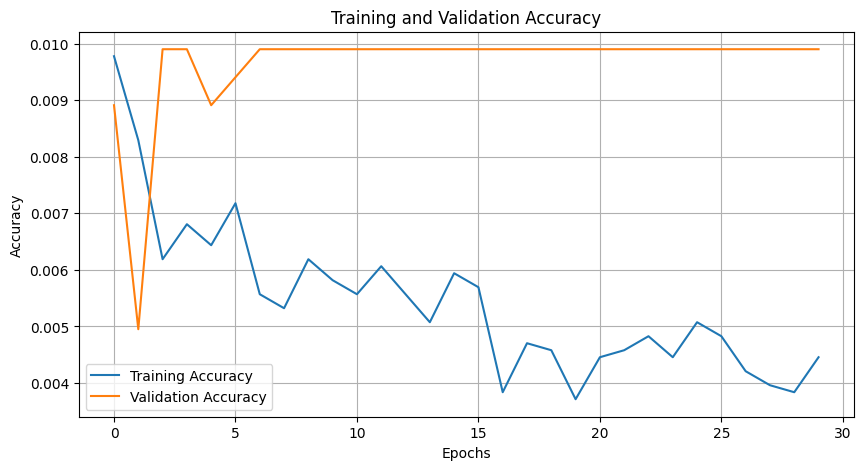

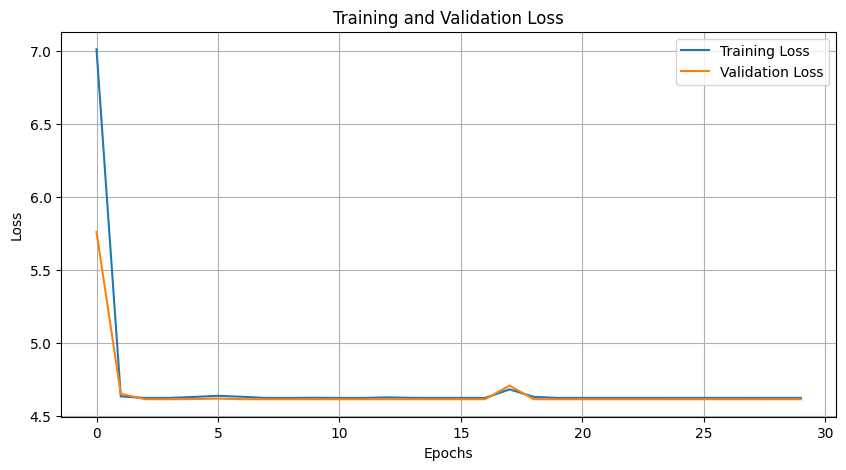

In [20]:
import matplotlib.pyplot as plt
train_acc = history_improved.history['accuracy']
val_acc = history_improved.history['val_accuracy']
train_loss = history_improved.history['loss']
val_loss = history_improved.history['val_loss']

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [7]:
print(history_improved.history)
model.save('food_model1.h5')


{'accuracy': [0.00977722741663456, 0.008292078971862793, 0.006188118830323219, 0.006806930527091026, 0.006435643415898085, 0.007178217638283968, 0.005569307133555412, 0.00532178208231926, 0.006188118830323219, 0.005816831719130278, 0.005569307133555412, 0.006064356304705143, 0.005569307133555412, 0.005074257496744394, 0.005940594244748354, 0.005693069193512201, 0.003836633637547493, 0.004702970385551453, 0.004579207859933376, 0.0037128713447600603, 0.0044554453343153, 0.004579207859933376, 0.004826732445508242, 0.0044554453343153, 0.005074257496744394, 0.004826732445508242, 0.004207920748740435, 0.003960396163165569, 0.003836633637547493, 0.0044554453343153], 'loss': [7.012027740478516, 4.6343841552734375, 4.623933792114258, 4.624077796936035, 4.630719184875488, 4.638486862182617, 4.631968975067139, 4.623785972595215, 4.623809814453125, 4.625180244445801, 4.623746871948242, 4.623861789703369, 4.627945899963379, 4.624513149261475, 4.623878479003906, 4.62407112121582, 4.6239800453186035,

Test accuracy: 0.0099
[[0.009566   0.009565   0.00955974 0.00956302 0.00956657 0.00958393
  0.00956069 0.00955675 0.00955203 0.0095667  0.00956492 0.00956627
  0.00956793 0.00958615 0.00958865 0.00959948 0.00961931 0.00960458
  0.00961182 0.00963296 0.00965995 0.00966175 0.0096572  0.00968326
  0.00967535 0.00969562 0.00970683 0.00971667 0.00973376 0.00972682
  0.00974179 0.00974983 0.00976209 0.00974278 0.00976407 0.00979555
  0.00979208 0.00979835 0.00981289 0.00980722 0.00983087 0.00984685
  0.0098492  0.0098587  0.00985329 0.00987149 0.00987244 0.0098914
  0.00989988 0.00991686 0.00992581 0.00993792 0.00990898 0.00995393
  0.00996157 0.00996009 0.00996768 0.00997369 0.00999948 0.00998007
  0.0100212  0.00999939 0.01000675 0.01002332 0.01001556 0.01002615
  0.01003485 0.01004656 0.01007727 0.01006851 0.01008298 0.01008703
  0.01011265 0.01011054 0.01012094 0.01010747 0.01014293 0.0101398
  0.01015448 0.01010658 0.01017559 0.01015134 0.01021497 0.01017808
  0.01020437 0.01017872 0.01

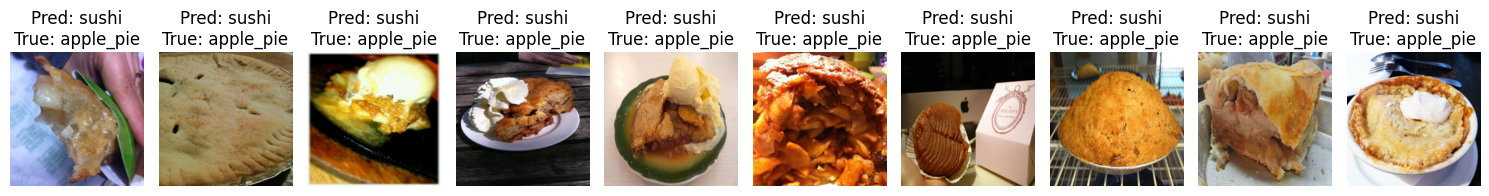

In [21]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def predict_image(image_path, model, class_labels):
    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))  # Resize to model's input size
    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    img_array = tf.image.per_image_standardization(img_array)  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the TensorFlow model
    predictions = model.predict(img_array, verbose=0)
    predicted_index = np.argmax(predictions.squeeze())  # Remove batch dimension and get max index

    return class_labels[predicted_index]

def show_and_predict_dataset_images(dataset, model, class_labels, num_images=3):
    # Create an unbatched dataset
    unbatched_dataset = dataset.unbatch()
    
    # Create a list to store samples
    samples = []
    
    # Extract samples from the dataset
    for image, label in unbatched_dataset.take(num_images):
        samples.append((image.numpy(), label.numpy()))
    
    # Create subplot
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    if num_images == 1:
        axs = [axs]  # Make axs iterable when only one image

    for i, (image_array, true_label) in enumerate(samples):
        # Handle different possible input shapes
        if len(image_array.shape) > 3:
            image_array = tf.squeeze(image_array)
        
        # Create a copy for display
        display_image = image_array.copy()
        
        # Denormalize if necessary
        if display_image.max() <= 1.0:
            display_image = (display_image * 255).astype(np.uint8)
        
        # Prepare image for model prediction
        preprocessed_image = tf.convert_to_tensor(image_array)
        preprocessed_image = tf.expand_dims(preprocessed_image, 0)  # Add batch dimension
        
        # Make prediction
        predictions = model.predict(preprocessed_image, verbose=0)
        print(predictions)
        predicted_idx = np.argmax(predictions)  # Remove batch dimension and get max index
        
        # Get class labels
        predicted_label = class_labels[predicted_idx]
        true_class = class_labels[true_label]
        
        # Display image and predictions
        axs[i].imshow(display_image)
        axs[i].set_title(f'Pred: {predicted_label}\nTrue: {true_class}')
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

    # Evaluate model
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

# Get class labels
classes = label_encoder.classes_

# Show predictions
show_and_predict_dataset_images(test_dataset, model, classes, num_images=10)